In [1]:
import pickle

import numpy as np

import torch

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from tqdm import tqdm



class CIFAR10InMemoryDataset(Dataset):

    def __init__(self, data, labels, transform=None):

        self.data = data

        self.labels = labels

        self.transform = transform

    

    def __len__(self):

        return len(self.data)

    

    def __getitem__(self, idx):

        image = self.data[idx]

        label = self.labels[idx]

        if self.transform:

            image = self.transform(image)

        return image, label



# Preload data into memory

def load_cifar10_in_memory(data_dir):

    images, labels = [], []

    for i in range(1, 6):

        with open(f"{data_dir}/data_batch_{i}", 'rb') as f:

            batch = pickle.load(f, encoding='bytes')

            images.append(batch[b'data'])

            labels.extend(batch[b'labels'])

    images = np.vstack(images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape and reorder dimensions

    labels = np.array(labels)



    # Load test data

    with open(f"{data_dir}/test_batch", 'rb') as f:

        batch = pickle.load(f, encoding='bytes')

        test_images = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

        test_labels = np.array(batch[b'labels'])

        

    return images, labels, test_images, test_labels



# Load CIFAR-10 data into memory

data_dir = "/kaggle/input/cifar-dataset/cifar-10-batches-py"

train_images, train_labels, test_images, test_labels = load_cifar10_in_memory(data_dir)



# Define simple transforms

train_transforms = transforms.Compose([

    transforms.ToTensor(),

    transforms.RandomCrop(32, padding=4),

    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.RandomHorizontalFlip(),

    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

])



# from torchvision import transforms



# train_transforms = transforms.Compose([

#     transforms.RandomCrop(32, padding=4),

#     transforms.RandomHorizontalFlip(),

#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

#     transforms.ToTensor(),

#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

# ])





test_transforms = transforms.Compose([

    transforms.ToTensor(),

    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

])



# Create in-memory datasets

train_dataset = CIFAR10InMemoryDataset(train_images, train_labels, transform=train_transforms)

test_dataset = CIFAR10InMemoryDataset(test_images, test_labels, transform=test_transforms)



# Create DataLoaders with fewer workers

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)


### Hybrid Model

In [2]:
import torch

import torch.nn as nn

import torch.nn.functional as F



class PatchEmbedding(nn.Module):

    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=64):

        super().__init__()

        self.num_patches = (img_size // patch_size) ** 2

        self.patch_size = patch_size

        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)



    def forward(self, x):

        x = self.proj(x)  # Shape: (batch_size, embed_dim, num_patches**0.5, num_patches**0.5)

        x = x.flatten(2)  # Flatten the spatial dimensions

        x = x.transpose(1, 2)  # Shape: (batch_size, num_patches, embed_dim)

        return x



class HybridCNN(nn.Module):

    def __init__(self, embed_dim=64):

        super().__init__()

        self.conv1 = nn.Conv2d(embed_dim, 128, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial dimensions

        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        

        # Adjust fc layer to match the flattened size

        self.fc = nn.Linear(1024, 512)  # 256 * 2 * 2 = 1024



    def forward(self, x):

        batch_size, num_patches, embed_dim = x.shape

        patch_size = int(num_patches**0.5)

        

        # Reshape x for CNN input

        x = x.transpose(1, 2).view(batch_size, embed_dim, patch_size, patch_size)

        

        # CNN layers

        x = F.relu(self.conv1(x))

        x = self.pool(F.relu(self.conv2(x)))

        x = self.pool(F.relu(self.conv3(x)))



        # Flatten for MLP input

        x = x.view(batch_size, -1)  # Shape will be (batch_size, 1024)

        x = F.relu(self.fc(x))

        return x





class HybridMLPClassifier(nn.Module):

    def __init__(self, in_features=512, num_classes=10):

        super().__init__()

        self.fc1 = nn.Linear(in_features, 256)

        self.fc2 = nn.Linear(256, 128)

        self.fc3 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.5)

        

    def forward(self, x):

        x = F.relu(self.fc1(x))

        x = self.dropout(x)

        x = F.relu(self.fc2(x))

        x = self.dropout(x)

        x = self.fc3(x)

        return x



class HybridModel(nn.Module):

    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=64, num_classes=10):

        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        self.cnn_feature_extractor = HybridCNN(embed_dim)

        self.classifier = HybridMLPClassifier(in_features=512, num_classes=num_classes)

    

    def forward(self, x):

        x = self.patch_embed(x)  # Shape: (batch_size, num_patches, embed_dim)

        x = self.cnn_feature_extractor(x)  # Shape: (batch_size, 512)

        x = self.classifier(x)  # Shape: (batch_size, num_classes)

        return x


In [3]:
from tqdm import tqdm

import torch

import torch.nn as nn

import torch.optim as optim

import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Initialize the HybridModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HybridModel(img_size=32, patch_size=4, in_channels=3, embed_dim=64, num_classes=10).to(device)



# Define criterion and optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)



# Early stopping parameters

patience = 3

best_loss = np.inf

epochs_no_improve = 0



# Lists to store loss values for plotting

train_losses = []

val_losses = []



# Training function

def train(model, loader):

    model.train()

    total_loss = 0

    for images, labels in tqdm(loader, desc="Training"):

        images, labels = images.to(device), labels.to(device).long()

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)



# Evaluation function with softmax for probabilities

def evaluate(model, loader):

    model.eval()

    preds, true_labels = [], []

    logits_list = []

    with torch.no_grad():

        for images, labels in tqdm(loader, desc="Evaluating"):

            images, labels = images.to(device), labels.to(device).long()

            outputs = model(images)  # Raw logits

            logits_list.append(outputs)  # Collect logits for validation loss calculation

            probs = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities

            _, predicted = torch.max(probs, 1)  # Get predicted classes

            preds.extend(predicted.cpu().numpy())

            true_labels.extend(labels.cpu().numpy())

    return preds, true_labels, torch.cat(logits_list)



# Training loop with early stopping and loss tracking

n_epochs = 50

for epoch in range(n_epochs):

    # Training step

    train_loss = train(model, train_loader)

    train_losses.append(train_loss)  # Store training loss for this epoch

    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}")

    

    # Validation step

    preds, true_labels, logits_tensor = evaluate(model, test_loader)

    accuracy = accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro')

    recall = recall_score(true_labels, preds, average='macro')

    f1 = f1_score(true_labels, preds, average='macro')

    

    # Calculate validation loss using logits

    val_loss = criterion(logits_tensor, torch.tensor(true_labels).to(device).long()).item()

    val_losses.append(val_loss)  # Store validation loss for plotting

    

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    

    # Early stopping logic

    if val_loss < best_loss:

        best_loss = val_loss

        epochs_no_improve = 0

        best_model = model.state_dict()

    else:

        epochs_no_improve += 1

    

    # Check if early stopping criterion is met

    if epochs_no_improve == patience:

        print("Early stopping triggered. Restoring the best model.")

        model.load_state_dict(best_model)

        break

    

    # Step the learning rate scheduler after each epoch

    scheduler.step()



# Restore the model with the lowest validation loss after training

# model.load_state_dict(best_model)

torch.save(best_model, 'hybrid_cnn_mlp_best_model.pth')

print("Model saved as 'hybrid_cnn_mlp_best_model.pth'")


Training: 100%|██████████| 391/391 [01:16<00:00,  5.11it/s]


Epoch 1, Training Loss: 1.9273


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 61.10it/s]


Validation Loss: 1.6583, Accuracy: 0.3571, Precision: 0.3568, Recall: 0.3571, F1-Score: 0.2941


Training: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]


Epoch 2, Training Loss: 1.6166


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.88it/s]


Validation Loss: 1.4039, Accuracy: 0.4873, Precision: 0.5032, Recall: 0.4873, F1-Score: 0.4775


Training: 100%|██████████| 391/391 [01:14<00:00,  5.22it/s]


Epoch 3, Training Loss: 1.4394


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 62.02it/s]


Validation Loss: 1.2147, Accuracy: 0.5642, Precision: 0.5763, Recall: 0.5642, F1-Score: 0.5631


Training: 100%|██████████| 391/391 [01:14<00:00,  5.23it/s]


Epoch 4, Training Loss: 1.3120


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 62.95it/s]


Validation Loss: 1.1403, Accuracy: 0.5942, Precision: 0.5883, Recall: 0.5942, F1-Score: 0.5841


Training: 100%|██████████| 391/391 [01:15<00:00,  5.17it/s]


Epoch 5, Training Loss: 1.2307


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 63.75it/s]


Validation Loss: 1.0818, Accuracy: 0.6239, Precision: 0.6240, Recall: 0.6239, F1-Score: 0.6208


Training: 100%|██████████| 391/391 [01:15<00:00,  5.18it/s]


Epoch 6, Training Loss: 1.1632


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.91it/s]


Validation Loss: 1.0652, Accuracy: 0.6358, Precision: 0.6343, Recall: 0.6358, F1-Score: 0.6256


Training: 100%|██████████| 391/391 [01:14<00:00,  5.22it/s]


Epoch 7, Training Loss: 1.1163


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 62.17it/s]


Validation Loss: 0.9795, Accuracy: 0.6616, Precision: 0.6591, Recall: 0.6616, F1-Score: 0.6564


Training: 100%|██████████| 391/391 [01:15<00:00,  5.21it/s]


Epoch 8, Training Loss: 1.0634


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 63.84it/s]


Validation Loss: 0.9653, Accuracy: 0.6636, Precision: 0.6642, Recall: 0.6636, F1-Score: 0.6553


Training: 100%|██████████| 391/391 [01:15<00:00,  5.19it/s]


Epoch 9, Training Loss: 1.0417


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.34it/s]


Validation Loss: 0.9676, Accuracy: 0.6659, Precision: 0.6772, Recall: 0.6659, F1-Score: 0.6635


Training: 100%|██████████| 391/391 [01:15<00:00,  5.15it/s]


Epoch 10, Training Loss: 0.9955


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.69it/s]


Validation Loss: 0.9024, Accuracy: 0.6874, Precision: 0.6900, Recall: 0.6874, F1-Score: 0.6845


Training: 100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


Epoch 11, Training Loss: 0.8949


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 65.54it/s]


Validation Loss: 0.8263, Accuracy: 0.7140, Precision: 0.7117, Recall: 0.7140, F1-Score: 0.7118


Training: 100%|██████████| 391/391 [01:16<00:00,  5.13it/s]


Epoch 12, Training Loss: 0.8591


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 65.17it/s]


Validation Loss: 0.8151, Accuracy: 0.7202, Precision: 0.7166, Recall: 0.7202, F1-Score: 0.7168


Training: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


Epoch 13, Training Loss: 0.8479


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 63.64it/s]


Validation Loss: 0.7973, Accuracy: 0.7267, Precision: 0.7232, Recall: 0.7267, F1-Score: 0.7238


Training: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


Epoch 14, Training Loss: 0.8314


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 63.20it/s]


Validation Loss: 0.7883, Accuracy: 0.7280, Precision: 0.7250, Recall: 0.7280, F1-Score: 0.7251


Training: 100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


Epoch 15, Training Loss: 0.8209


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 61.03it/s]


Validation Loss: 0.7894, Accuracy: 0.7292, Precision: 0.7287, Recall: 0.7292, F1-Score: 0.7281


Training: 100%|██████████| 391/391 [01:16<00:00,  5.14it/s]


Epoch 16, Training Loss: 0.8093


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.36it/s]


Validation Loss: 0.7799, Accuracy: 0.7315, Precision: 0.7290, Recall: 0.7315, F1-Score: 0.7295


Training: 100%|██████████| 391/391 [01:17<00:00,  5.06it/s]


Epoch 17, Training Loss: 0.8091


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.56it/s]


Validation Loss: 0.7726, Accuracy: 0.7346, Precision: 0.7315, Recall: 0.7346, F1-Score: 0.7320


Training: 100%|██████████| 391/391 [01:16<00:00,  5.11it/s]


Epoch 18, Training Loss: 0.7943


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 65.59it/s]


Validation Loss: 0.7709, Accuracy: 0.7331, Precision: 0.7286, Recall: 0.7331, F1-Score: 0.7289


Training: 100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


Epoch 19, Training Loss: 0.7875


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 65.35it/s]


Validation Loss: 0.7672, Accuracy: 0.7367, Precision: 0.7346, Recall: 0.7367, F1-Score: 0.7342


Training: 100%|██████████| 391/391 [01:15<00:00,  5.15it/s]


Epoch 20, Training Loss: 0.7803


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 65.55it/s]


Validation Loss: 0.7713, Accuracy: 0.7330, Precision: 0.7325, Recall: 0.7330, F1-Score: 0.7309


Training: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


Epoch 21, Training Loss: 0.7692


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.12it/s]


Validation Loss: 0.7604, Accuracy: 0.7369, Precision: 0.7346, Recall: 0.7369, F1-Score: 0.7348


Training: 100%|██████████| 391/391 [01:16<00:00,  5.14it/s]


Epoch 22, Training Loss: 0.7682


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.34it/s]


Validation Loss: 0.7587, Accuracy: 0.7375, Precision: 0.7355, Recall: 0.7375, F1-Score: 0.7356


Training: 100%|██████████| 391/391 [01:16<00:00,  5.14it/s]


Epoch 23, Training Loss: 0.7623


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 65.78it/s]


Validation Loss: 0.7582, Accuracy: 0.7377, Precision: 0.7353, Recall: 0.7377, F1-Score: 0.7355


Training: 100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


Epoch 24, Training Loss: 0.7646


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 65.19it/s]


Validation Loss: 0.7562, Accuracy: 0.7390, Precision: 0.7363, Recall: 0.7390, F1-Score: 0.7367


Training: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


Epoch 25, Training Loss: 0.7648


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.15it/s]


Validation Loss: 0.7568, Accuracy: 0.7375, Precision: 0.7350, Recall: 0.7375, F1-Score: 0.7353


Training: 100%|██████████| 391/391 [01:15<00:00,  5.15it/s]


Epoch 26, Training Loss: 0.7639


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.33it/s]


Validation Loss: 0.7565, Accuracy: 0.7384, Precision: 0.7356, Recall: 0.7384, F1-Score: 0.7359


Training: 100%|██████████| 391/391 [01:15<00:00,  5.19it/s]


Epoch 27, Training Loss: 0.7635


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.61it/s]


Validation Loss: 0.7546, Accuracy: 0.7388, Precision: 0.7363, Recall: 0.7388, F1-Score: 0.7366


Training: 100%|██████████| 391/391 [01:15<00:00,  5.20it/s]


Epoch 28, Training Loss: 0.7610


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.35it/s]


Validation Loss: 0.7532, Accuracy: 0.7394, Precision: 0.7370, Recall: 0.7394, F1-Score: 0.7374


Training: 100%|██████████| 391/391 [01:15<00:00,  5.18it/s]


Epoch 29, Training Loss: 0.7598


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 65.02it/s]


Validation Loss: 0.7538, Accuracy: 0.7399, Precision: 0.7382, Recall: 0.7399, F1-Score: 0.7381


Training: 100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


Epoch 30, Training Loss: 0.7594


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.64it/s]


Validation Loss: 0.7529, Accuracy: 0.7403, Precision: 0.7381, Recall: 0.7403, F1-Score: 0.7383


Training: 100%|██████████| 391/391 [01:15<00:00,  5.21it/s]


Epoch 31, Training Loss: 0.7556


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.73it/s]


Validation Loss: 0.7528, Accuracy: 0.7396, Precision: 0.7373, Recall: 0.7396, F1-Score: 0.7375


Training: 100%|██████████| 391/391 [01:15<00:00,  5.18it/s]


Epoch 32, Training Loss: 0.7619


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 63.83it/s]


Validation Loss: 0.7527, Accuracy: 0.7397, Precision: 0.7373, Recall: 0.7397, F1-Score: 0.7376


Training: 100%|██████████| 391/391 [01:14<00:00,  5.25it/s]


Epoch 33, Training Loss: 0.7514


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.72it/s]


Validation Loss: 0.7527, Accuracy: 0.7395, Precision: 0.7372, Recall: 0.7395, F1-Score: 0.7374


Training: 100%|██████████| 391/391 [01:15<00:00,  5.21it/s]


Epoch 34, Training Loss: 0.7564


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 62.50it/s]


Validation Loss: 0.7526, Accuracy: 0.7396, Precision: 0.7373, Recall: 0.7396, F1-Score: 0.7375


Training: 100%|██████████| 391/391 [01:15<00:00,  5.17it/s]


Epoch 35, Training Loss: 0.7588


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.56it/s]


Validation Loss: 0.7527, Accuracy: 0.7390, Precision: 0.7367, Recall: 0.7390, F1-Score: 0.7369


Training: 100%|██████████| 391/391 [01:15<00:00,  5.21it/s]


Epoch 36, Training Loss: 0.7546


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.97it/s]


Validation Loss: 0.7526, Accuracy: 0.7394, Precision: 0.7369, Recall: 0.7394, F1-Score: 0.7372


Training: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


Epoch 37, Training Loss: 0.7559


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 65.86it/s]


Validation Loss: 0.7526, Accuracy: 0.7393, Precision: 0.7370, Recall: 0.7393, F1-Score: 0.7372


Training: 100%|██████████| 391/391 [01:15<00:00,  5.19it/s]


Epoch 38, Training Loss: 0.7533


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.71it/s]


Validation Loss: 0.7525, Accuracy: 0.7392, Precision: 0.7369, Recall: 0.7392, F1-Score: 0.7370


Training: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s]


Epoch 39, Training Loss: 0.7585


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 62.83it/s]


Validation Loss: 0.7525, Accuracy: 0.7394, Precision: 0.7371, Recall: 0.7394, F1-Score: 0.7372


Training: 100%|██████████| 391/391 [01:14<00:00,  5.22it/s]


Epoch 40, Training Loss: 0.7584


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.36it/s]


Validation Loss: 0.7523, Accuracy: 0.7395, Precision: 0.7372, Recall: 0.7395, F1-Score: 0.7374


Training: 100%|██████████| 391/391 [01:14<00:00,  5.23it/s]


Epoch 41, Training Loss: 0.7570


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.33it/s]


Validation Loss: 0.7523, Accuracy: 0.7395, Precision: 0.7372, Recall: 0.7395, F1-Score: 0.7374


Training: 100%|██████████| 391/391 [01:16<00:00,  5.14it/s]


Epoch 42, Training Loss: 0.7546


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 67.33it/s]


Validation Loss: 0.7523, Accuracy: 0.7395, Precision: 0.7372, Recall: 0.7395, F1-Score: 0.7374


Training: 100%|██████████| 391/391 [01:14<00:00,  5.26it/s]


Epoch 43, Training Loss: 0.7591


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.78it/s]


Validation Loss: 0.7523, Accuracy: 0.7394, Precision: 0.7370, Recall: 0.7394, F1-Score: 0.7373


Training: 100%|██████████| 391/391 [01:14<00:00,  5.22it/s]


Epoch 44, Training Loss: 0.7583


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 52.43it/s]


Validation Loss: 0.7523, Accuracy: 0.7393, Precision: 0.7370, Recall: 0.7393, F1-Score: 0.7372


Training: 100%|██████████| 391/391 [01:14<00:00,  5.22it/s]


Epoch 45, Training Loss: 0.7538


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 67.29it/s]


Validation Loss: 0.7523, Accuracy: 0.7393, Precision: 0.7370, Recall: 0.7393, F1-Score: 0.7372


Training: 100%|██████████| 391/391 [01:14<00:00,  5.22it/s]


Epoch 46, Training Loss: 0.7584


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 64.32it/s]


Validation Loss: 0.7522, Accuracy: 0.7393, Precision: 0.7369, Recall: 0.7393, F1-Score: 0.7371


Training: 100%|██████████| 391/391 [01:15<00:00,  5.15it/s]


Epoch 47, Training Loss: 0.7601


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.53it/s]


Validation Loss: 0.7522, Accuracy: 0.7395, Precision: 0.7372, Recall: 0.7395, F1-Score: 0.7374


Training: 100%|██████████| 391/391 [01:15<00:00,  5.19it/s]


Epoch 48, Training Loss: 0.7541


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.58it/s]


Validation Loss: 0.7522, Accuracy: 0.7395, Precision: 0.7372, Recall: 0.7395, F1-Score: 0.7374


Training: 100%|██████████| 391/391 [01:15<00:00,  5.17it/s]


Epoch 49, Training Loss: 0.7573


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.37it/s]


Validation Loss: 0.7522, Accuracy: 0.7394, Precision: 0.7371, Recall: 0.7394, F1-Score: 0.7373


Training: 100%|██████████| 391/391 [01:16<00:00,  5.13it/s]


Epoch 50, Training Loss: 0.7564


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 66.14it/s]

Validation Loss: 0.7522, Accuracy: 0.7393, Precision: 0.7370, Recall: 0.7393, F1-Score: 0.7372
Model saved as 'hybrid_cnn_mlp_best_model.pth'


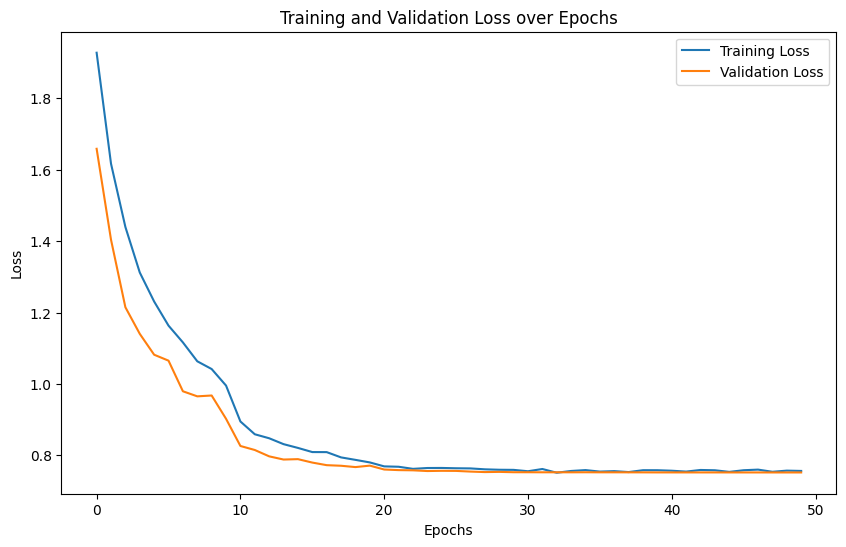

In [4]:
import matplotlib.pyplot as plt



# Plot Training and Validation Loss

plt.figure(figsize=(10, 6))

plt.plot(train_losses, label="Training Loss")

plt.plot(val_losses, label="Validation Loss")

plt.xlabel("Epochs")

plt.ylabel("Loss")

plt.title("Training and Validation Loss over Epochs")

plt.legend()

plt.show()


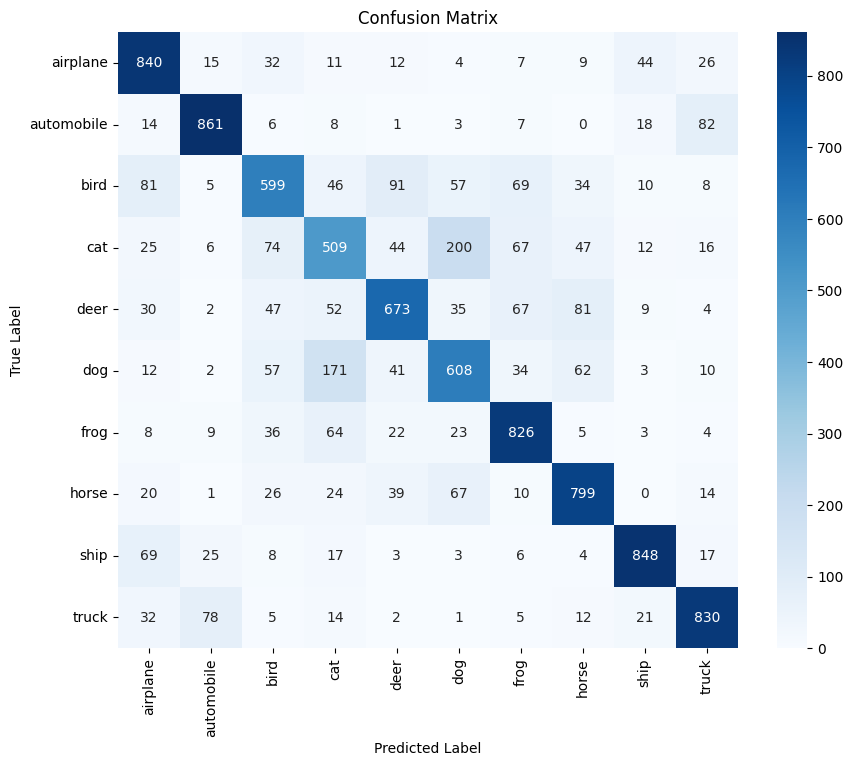

In [5]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt



def plot_confusion_matrix(true_labels, preds, class_names):

    # Generate the confusion matrix

    cm = confusion_matrix(true_labels, preds)

    

    # Plot the confusion matrix

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Label")

    plt.ylabel("True Label")

    plt.title("Confusion Matrix")

    plt.show()



# Assuming `class_names` contains the names of your classes

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



# Example usage after evaluating the model

plot_confusion_matrix(true_labels, preds, class_names)
